# Split 7:3

In [52]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [53]:
df = pd.read_csv('FPT.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,19296.671875,19318.330078,19123.414063,19318.330078,1410097.0
1,2019-03-04,19318.330078,19578.216797,19318.330078,19491.587891,1931839.0
2,2019-03-05,19491.587891,19578.216797,19404.958984,19448.273438,1903047.0
3,2019-03-06,19469.929688,19534.902344,19253.357422,19318.330078,1605064.0
4,2019-03-07,19318.330078,19491.587891,19318.330078,19383.300781,864232.0
...,...,...,...,...,...,...
1318,2024-06-10,124781.859375,126086.203125,124347.078125,125216.640625,4341736.0
1319,2024-06-11,125478.257813,127391.304688,124434.781250,127391.304688,9681274.0
1320,2024-06-12,127900.000000,132700.000000,127800.000000,132000.000000,11215500.0
1321,2024-06-13,133700.000000,133800.000000,130000.000000,130000.000000,8676200.0


In [54]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [55]:
df['time'] = pd.to_datetime(df['time'])

In [56]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1323 non-null   datetime64[ns]
 1   close   1323 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [57]:
df = df.set_index('time')

In [58]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

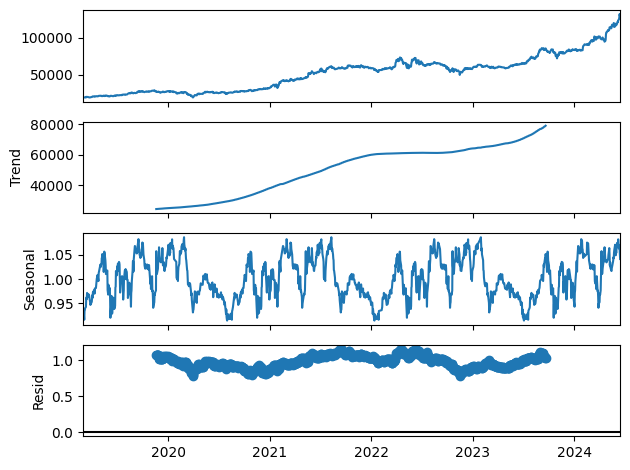

In [59]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [60]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [61]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [62]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=249, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [63]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


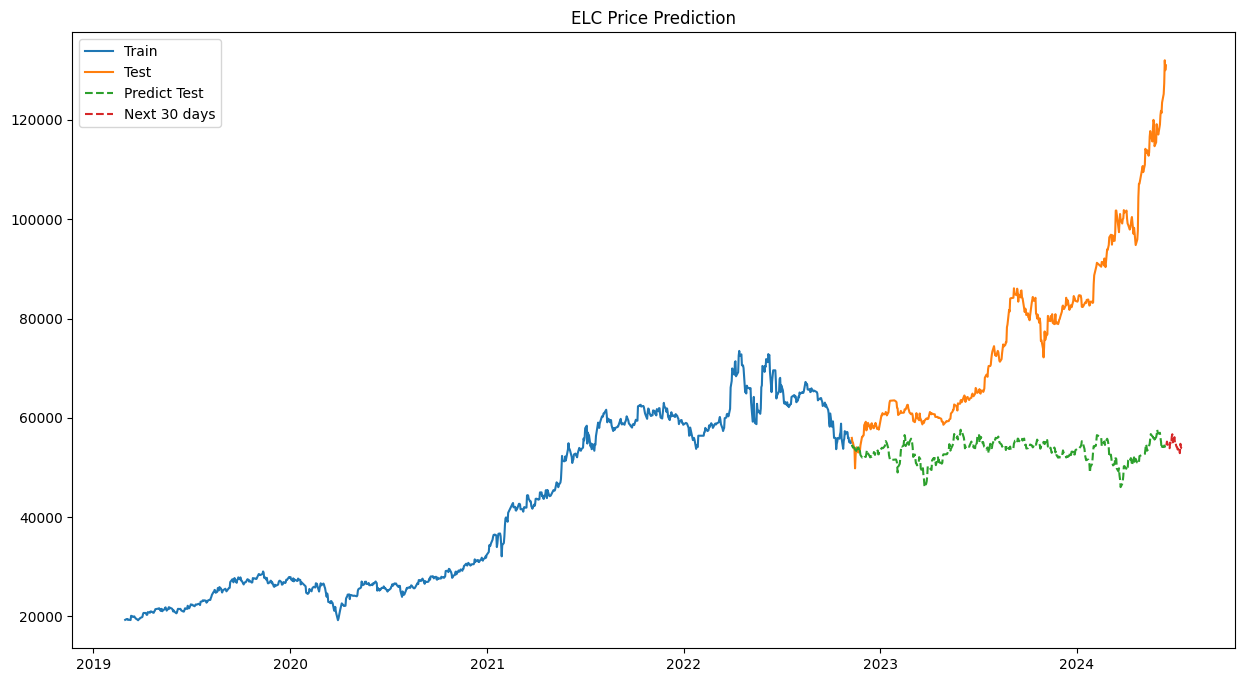

In [64]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index, train['close'], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [65]:
evaluateModel(test, pred)

** Testing **
MAE:  23833.054836322597
MAPE:  27.42149637073881
RMSE:  29924.835178269812
MSLE: 0.1684596579335805


In [66]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                  926
Model:             ExponentialSmoothing   SSE                      792603354.172
Optimized:                         True   AIC                          13157.122
Trend:                   Multiplicative   BIC                          14384.164
Seasonal:                Multiplicative   AICC                         13353.810
Seasonal Periods:                   249   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:50:23
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9596429                alpha                 True
smoothing_trend       

# Split 8:2

In [67]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [68]:
df = pd.read_csv('FPT.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,19296.671875,19318.330078,19123.414063,19318.330078,1410097.0
1,2019-03-04,19318.330078,19578.216797,19318.330078,19491.587891,1931839.0
2,2019-03-05,19491.587891,19578.216797,19404.958984,19448.273438,1903047.0
3,2019-03-06,19469.929688,19534.902344,19253.357422,19318.330078,1605064.0
4,2019-03-07,19318.330078,19491.587891,19318.330078,19383.300781,864232.0
...,...,...,...,...,...,...
1318,2024-06-10,124781.859375,126086.203125,124347.078125,125216.640625,4341736.0
1319,2024-06-11,125478.257813,127391.304688,124434.781250,127391.304688,9681274.0
1320,2024-06-12,127900.000000,132700.000000,127800.000000,132000.000000,11215500.0
1321,2024-06-13,133700.000000,133800.000000,130000.000000,130000.000000,8676200.0


In [69]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [70]:
df['time'] = pd.to_datetime(df['time'])

In [71]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1323 non-null   datetime64[ns]
 1   close   1323 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [72]:
df = df.set_index('time')

In [73]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

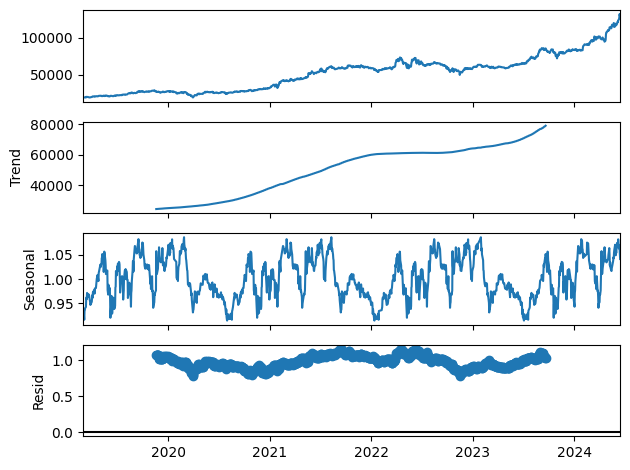

In [74]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [75]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [76]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

In [77]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=298, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [78]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


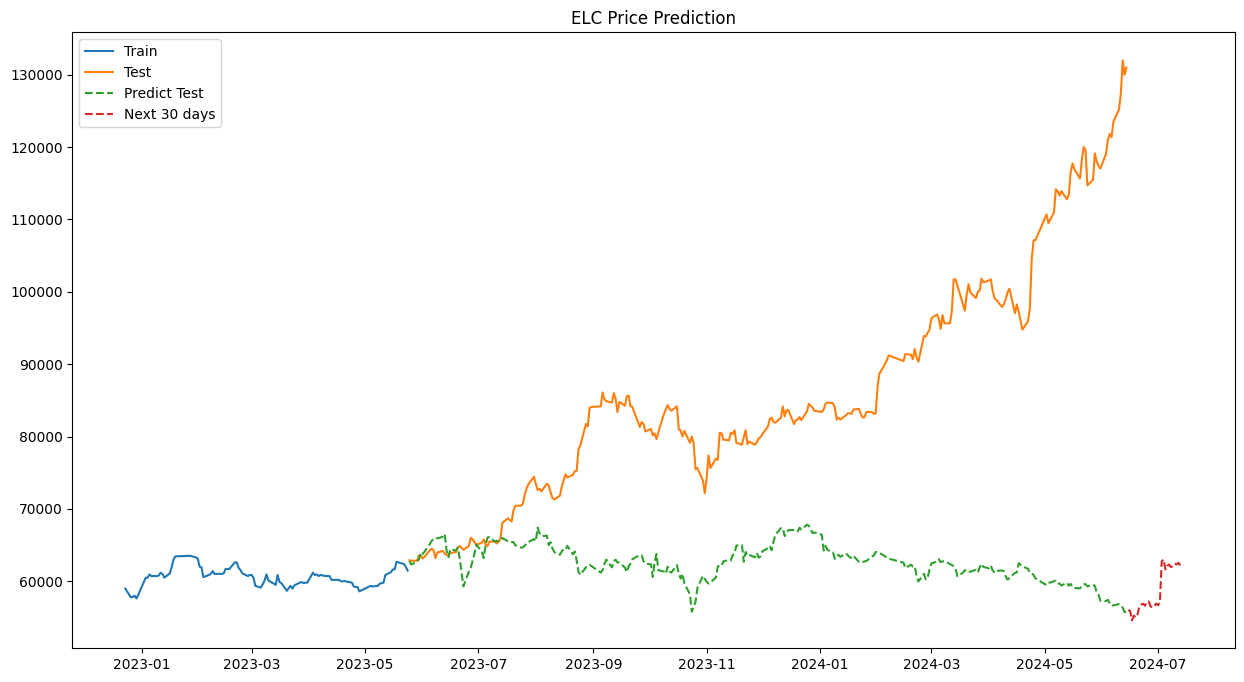

In [79]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [80]:
evaluateModel(test, pred)

** Testing **
MAE:  23541.14350489011
MAPE:  24.72045410220479
RMSE:  29416.00719808533
MSLE: 0.13464897544327997


In [81]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1058
Model:             ExponentialSmoothing   SSE                      974716083.334
Optimized:                         True   AIC                          15136.065
Trend:                   Multiplicative   BIC                          16640.198
Seasonal:                Multiplicative   AICC                         15384.283
Seasonal Periods:                   298   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:50:28
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Split 9:1

In [82]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import itertools
import warnings
import numpy as np

In [83]:
df = pd.read_csv('FPT.csv')
df

,time,open,high,low,close,volume
0,2019-03-01,19296.671875,19318.330078,19123.414063,19318.330078,1410097.0
1,2019-03-04,19318.330078,19578.216797,19318.330078,19491.587891,1931839.0
2,2019-03-05,19491.587891,19578.216797,19404.958984,19448.273438,1903047.0
3,2019-03-06,19469.929688,19534.902344,19253.357422,19318.330078,1605064.0
4,2019-03-07,19318.330078,19491.587891,19318.330078,19383.300781,864232.0
...,...,...,...,...,...,...
1318,2024-06-10,124781.859375,126086.203125,124347.078125,125216.640625,4341736.0
1319,2024-06-11,125478.257813,127391.304688,124434.781250,127391.304688,9681274.0
1320,2024-06-12,127900.000000,132700.000000,127800.000000,132000.000000,11215500.0
1321,2024-06-13,133700.000000,133800.000000,130000.000000,130000.000000,8676200.0


In [84]:

# Drop column that aren't use
df.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()


In [85]:
df['time'] = pd.to_datetime(df['time'])

In [86]:
# Check if data still contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1323 non-null   datetime64[ns]
 1   close   1323 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB


In [87]:
df = df.set_index('time')

In [88]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "time"

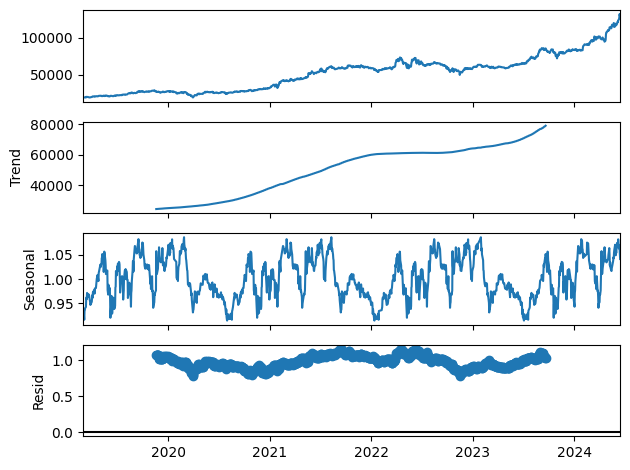

In [89]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

In [90]:
# Calculate the accuracy of each model
def evaluateModel(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.close.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  test_msle = mean_squared_log_error(test, pred)
  print('MSLE:', test_msle)

In [91]:
# 2. Split the data into training, testing, and validation sets
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train = df[:train_size]
test = df[train_size:]

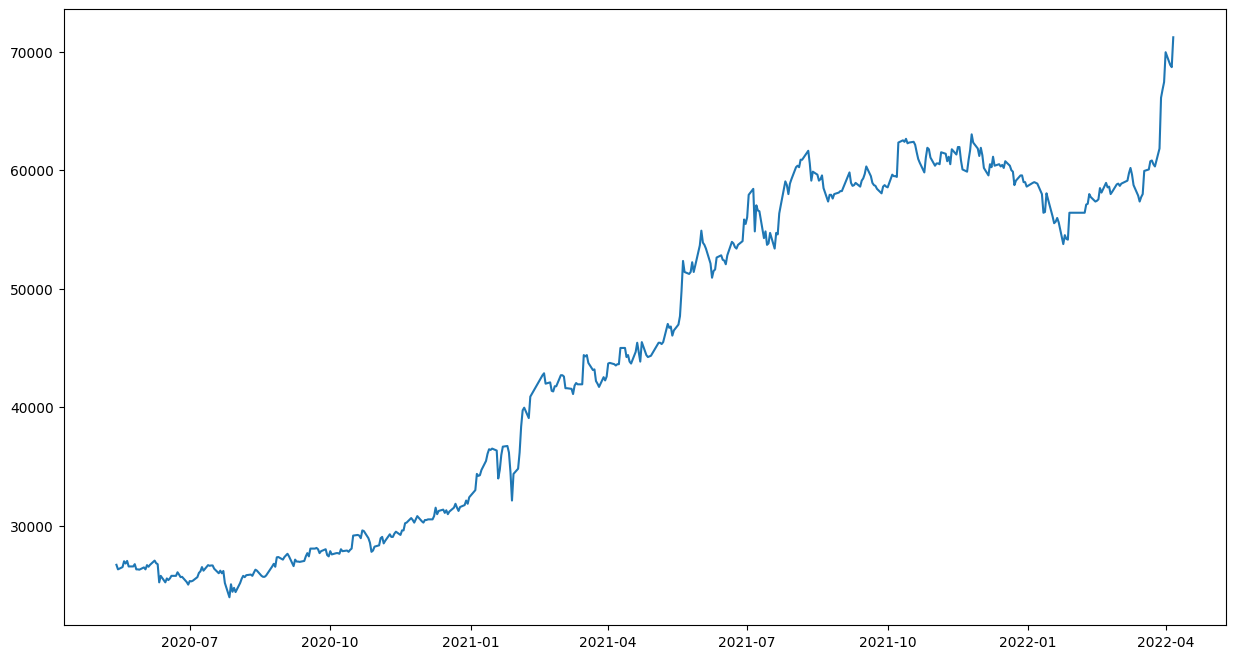

In [92]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['close'][300:777]);

In [93]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=348, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [94]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


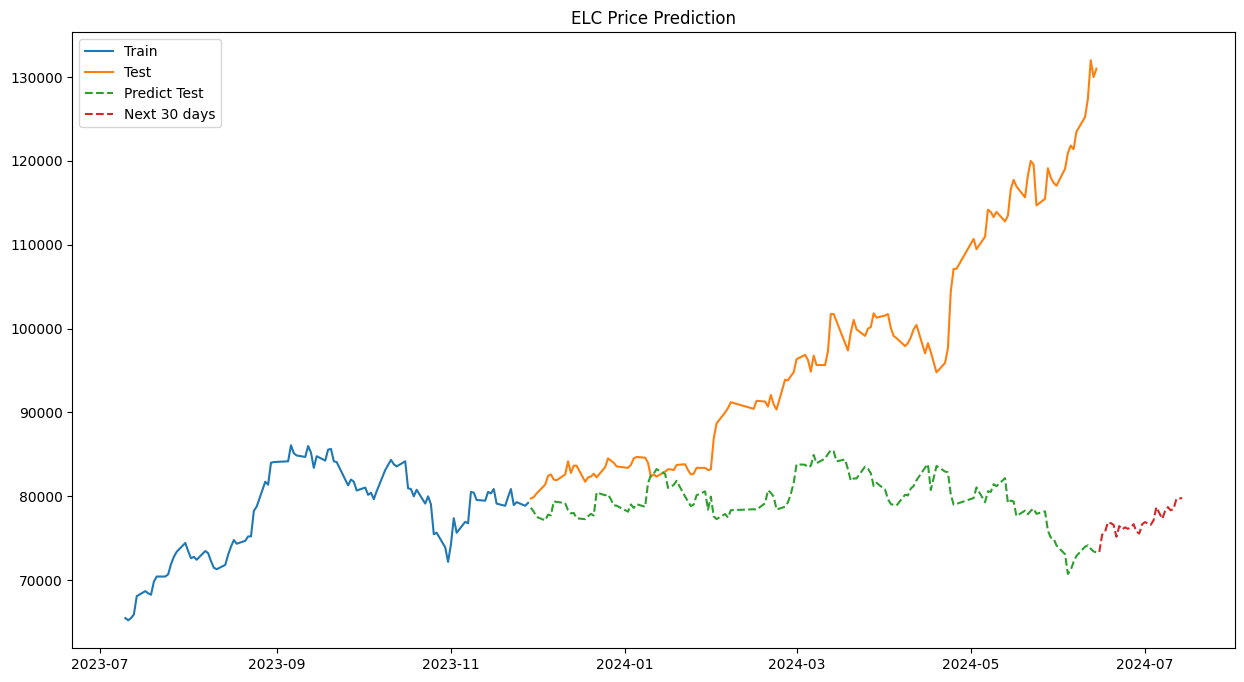

In [95]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['close'][train_size - 100:], label="Train");
ax.plot(test.index, test['close'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("ELC Price Prediction");

In [96]:
evaluateModel(test, pred)

** Testing **
MAE:  17800.90265957509
MAPE:  16.57485133213949
RMSE:  23432.459011379564
MSLE: 0.0612014217236347


In [97]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 1190
Model:             ExponentialSmoothing   SSE                      858707163.074
Optimized:                         True   AIC                          16758.184
Trend:                   Multiplicative   BIC                          18552.027
Seasonal:                Multiplicative   AICC                         17061.253
Seasonal Periods:                   348   Date:                 Sun, 16 Jun 2024
Box-Cox:                          False   Time:                         10:50:34
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       